# <center>  Валидация данных и оценка моделей. Практика


In [2]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import metrics #метрики
from sklearn import model_selection #методы разделения и валидации
from sklearn import ensemble #ансамбли

plt.style.use('seaborn') #стиль отрисовки seaborn
%matplotlib inline

C:\Users\Павел\AppData\Local\Temp\ipykernel_20204\2412469314.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn') #стиль отрисовки seaborn


In [3]:
shoppers_data = pd.read_csv('../data/online_shoppers_intention.csv')
shoppers_data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [5]:
# проверим размер таблицы
print(shoppers_data.shape)

(12330, 18)


In [6]:
# Проверим данные на пропуски
shoppers_data.isna().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

In [7]:
# перекодируем кодигориальные признаки
dummy_data = pd.get_dummies(shoppers_data)
dummy_data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1


>Итак, нам необходимо предсказать целевую переменную Revenue — признак покупки. Целевой признак является бинарным категориальным, то есть мы решаем задачу бинарной классификации. В первую очередь посмотрим на соотношение классов в данных:

Sessions without purchase : 84.53%
Sessions with purchase: 15.47%


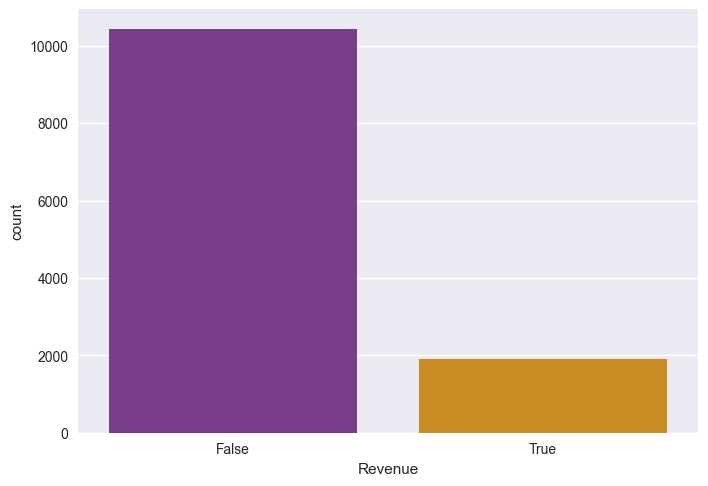

In [8]:
sns.countplot(x='Revenue', data=dummy_data, palette='CMRmap')
class_percent = dummy_data['Revenue'].value_counts(normalize=True) * 100
print('Sessions without purchase : {:.2f}%'.format(class_percent[0]))
print('Sessions with purchase: {:.2f}%'.format(class_percent[1]))

Из графика отчётливо видно, что мы имеем дело с несбалансированной выборкой, так как соотношение классов — 85/15, что далеко от сбалансированного соотношения 50/50.

Из 12 330 сессий покупкой товара завершаются лишь 15.47 %. Мы знаем, что такое соотношение классов заставляет нас смотреть на метрики для каждого из классов отдельно.

Условимся, что лучшей будет считаться та модель, у которой значение метрики $F-1$ для пользователей, совершивших покупку, будет наибольшим.

По традиции разделим набор данных на матрицу наблюдений X и вектор ответов y:

In [9]:
X, y = dummy_data.drop('Revenue', axis=1), dummy_data['Revenue']

In [13]:
# Разобъем выборку на тренировочную и валидационную с соотношением 80/20 со стратификацией
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(f'Количество сессий в тренеровочной выборке: {X_train.shape[0]}')
print(f'Количество сессий в валидационной выборке: {X_valid.shape[0]}')

Количество сессий в тренеровочной выборке: 9864
Количество сессий в валидационной выборке: 2466


In [20]:
# Создадим модель случайного лесса и проведем кросс валидацию на 5 фолдах
rdf = ensemble.RandomForestClassifier(random_state=42)
rdf.fit(X_train, y_train) # обучим модель на тренировочных данных
# Создадим объект кросс валидации по 5 фолдам
crf = model_selection.StratifiedKFold(n_splits=5)

#Считаем метрики на кросс-валидации k-fold со стратификацией
cv_metrics = model_selection.cross_validate(
    rdf,
    X_train,
    y_train,
    cv = crf,
    scoring='f1',
    return_train_score=True
)
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean f1: 1.00
Valid k-fold mean f1: 0.65


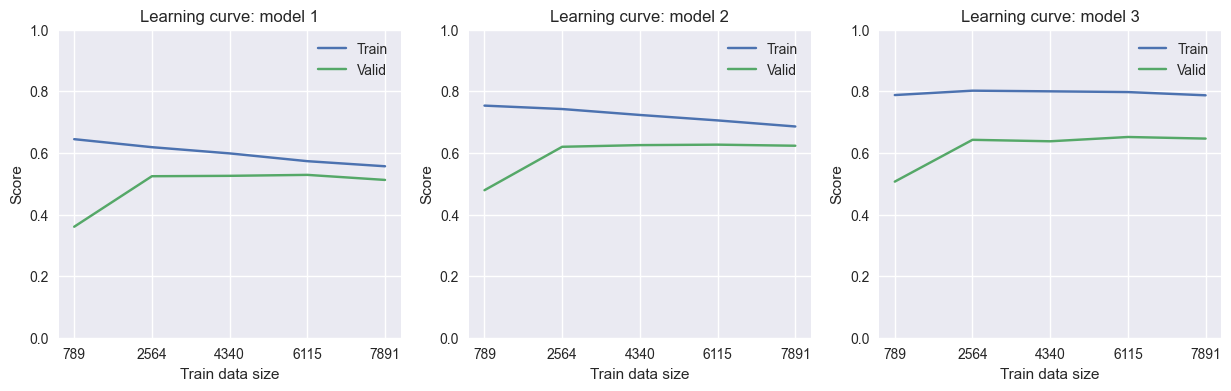

In [22]:
# создадим несколько моделей случайного леса, для построения кривых обучения
#Создаём список из моделей
models = [
    ensemble.RandomForestClassifier(
        n_estimators=200,
        max_depth=5,
        min_samples_leaf=5,
        random_state=42
    ),
    ensemble.RandomForestClassifier(
        n_estimators=200,
        max_depth=7,
        min_samples_leaf=5,
        random_state=42
    ),
    ensemble.RandomForestClassifier(
        n_estimators=200,
        max_depth=12,
        min_samples_leaf=5,
        random_state=42
    )
]

# создаим функцию построения кривой обучения
def plot_learning_curve(model, X, y, cv, scoring="f1", ax=None, title=""):
    # Вычисляем координаты для построения кривой обучения
    train_sizes, train_scores, valid_scores = model_selection.learning_curve(
        estimator=model,  # модель
        X=X,  # матрица наблюдений X
        y=y,  # вектор ответов y
        cv=cv,  # кросс-валидатор
        scoring=scoring,  # метрика
    )
    # Вычисляем среднее значение по фолдам для каждого набора данных
    train_scores_mean = np.mean(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    # Если координатной плоскости не было передано, создаём новую
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 4))  # фигура + координатная плоскость
    # Строим кривую обучения по метрикам на тренировочных фолдах
    ax.plot(train_sizes, train_scores_mean, label="Train")
    # Строим кривую обучения по метрикам на валидационных фолдах
    ax.plot(train_sizes, valid_scores_mean, label="Valid")
    # Даём название графику и подписи осям
    ax.set_title("Learning curve: {}".format(title))
    ax.set_xlabel("Train data size")
    ax.set_ylabel("Score")
    # Устанавливаем отметки по оси абсцисс
    ax.xaxis.set_ticks(train_sizes)
    # Устанавливаем диапазон оси ординат
    ax.set_ylim(0, 1)
    # Отображаем легенду
    ax.legend()
    
    
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
#Визуализируем кривые обучения
fig, axes = plt.subplots(1, 3, figsize=(15, 4)) #фигура + три координатных плоскости
#Создаём цикл по списку моделей и индексам этого списка
for i, model in enumerate(models): #i — текущий индекс, model — текущая модель
    plot_learning_curve(model, X=X_train, y=y_train, cv=skf, ax=axes[i], title=f'model {i+1}')

In [23]:
# обучим модель 2 и получим метрики по данной модели
model =ensemble.RandomForestClassifier(
    n_estimators=200,
    max_depth=7,
    min_samples_leaf=5,
    random_state=42
)
model.fit(X_train, y_train)

#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик    
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

       False       0.91      0.98      0.94      2084
        True       0.79      0.49      0.60       382

    accuracy                           0.90      2466
   macro avg       0.85      0.73      0.77      2466
weighted avg       0.89      0.90      0.89      2466



In [24]:
# обучим модель 2 и получим метрики по данной модели
model =ensemble.RandomForestClassifier(
    n_estimators=200,
    max_depth=7,
    min_samples_leaf=5,
    random_state=42
)
model.fit(X_train, y_train)

#Создаём кросс-валидатор k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
#Делаем предсказание вероятностей на кросс-валидации
y_cv_proba_pred = model_selection.cross_val_predict(model, X_train, y_train, cv=skf, method='predict_proba')
y_cv_proba_pred

array([[0.67751554, 0.32248446],
       [0.96913055, 0.03086945],
       [0.97981615, 0.02018385],
       ...,
       [0.98993487, 0.01006513],
       [0.47892495, 0.52107505],
       [0.30235619, 0.69764381]])

Best threshold = 0.36, F1-Score = 0.69


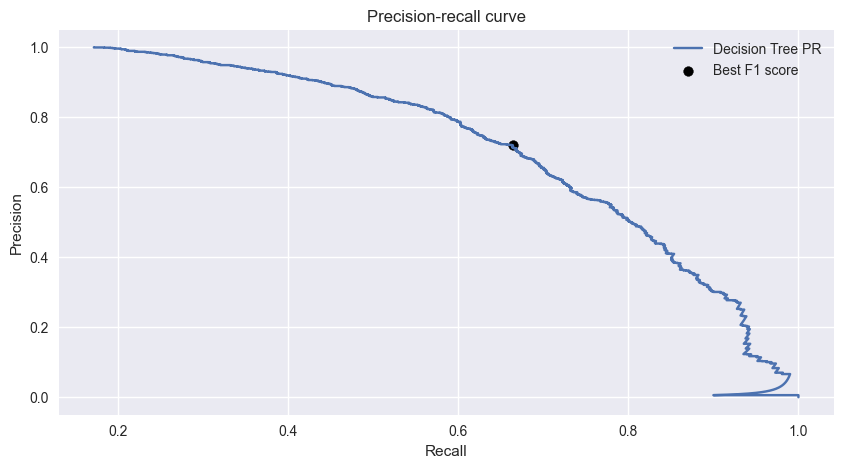

In [25]:
#Выделяем столбец с вероятностями для класса 1 True
y_cv_proba_pred = y_cv_proba_pred[:, 1]

#Вычисляем координаты PR-кривой
precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_cv_proba_pred)

#Вычисляем F1-score при различных threshold
f1_scores = (2 * precision * recall) / (precision + recall)
#Определяем индекс максимума
idx = np.argmax(f1_scores)
print('Best threshold = {:.2f}, F1-Score = {:.2f}'.format(thresholds[idx], f1_scores[idx]))
 
#Строим PR-кривую
fig, ax = plt.subplots(figsize=(10, 5)) #фигура + координатная плоскость
#Строим линейный график зависимости precision от recall
ax.plot(precision, recall, label='Decision Tree PR')
#Отмечаем точку максимума F1
ax.scatter(precision[idx], recall[idx], marker='o', color='black', label='Best F1 score')
#Даём графику название и подписываем оси
ax.set_title('Precision-recall curve')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
#Отображаем легенду
ax.legend();

In [26]:
# Клиенты вероятность которых > threshold_opt, относим к классу 1
#В противном случае — к классу 0
y_valid_pred_proba = model.predict_proba(X_valid)[:, 1]
y_valid_pred = (y_valid_pred_proba > thresholds[idx]).astype('int')
#Считаем метрики
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

       False       0.94      0.93      0.94      2084
        True       0.66      0.69      0.67       382

    accuracy                           0.90      2466
   macro avg       0.80      0.81      0.81      2466
weighted avg       0.90      0.90      0.90      2466



In [27]:
data = pd.read_excel('../data/data_ford_price.xlsx')
data.head()

,price,year,condition,cylinders,odometer,title_status,transmission,drive,size,lat,long,weather
0,43900,2016,4,6,43500,clean,automatic,4wd,full-size,36.471500,-82.483400,59.0
1,15490,2009,2,8,98131,clean,automatic,4wd,full-size,40.468826,-74.281734,52.0
2,2495,2002,2,8,201803,clean,automatic,4wd,full-size,42.477134,-82.949564,45.0
3,1300,2000,1,8,170305,rebuilt,automatic,4wd,full-size,40.764373,-82.349503,49.0
4,13865,2010,3,8,166062,clean,automatic,4wd,NaN,49.210949,-123.114720,NaN


In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7017 entries, 0 to 7016
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         7017 non-null   int64  
 1   year          7017 non-null   int64  
 2   condition     7017 non-null   int64  
 3   cylinders     7017 non-null   int64  
 4   odometer      7017 non-null   int64  
 5   title_status  7017 non-null   object 
 6   transmission  7017 non-null   object 
 7   drive         6626 non-null   object 
 8   size          5453 non-null   object 
 9   lat           7017 non-null   float64
 10  long          7017 non-null   float64
 11  weather       6837 non-null   float64
dtypes: float64(3), int64(5), object(4)
memory usage: 658.0+ KB


<AxesSubplot: >

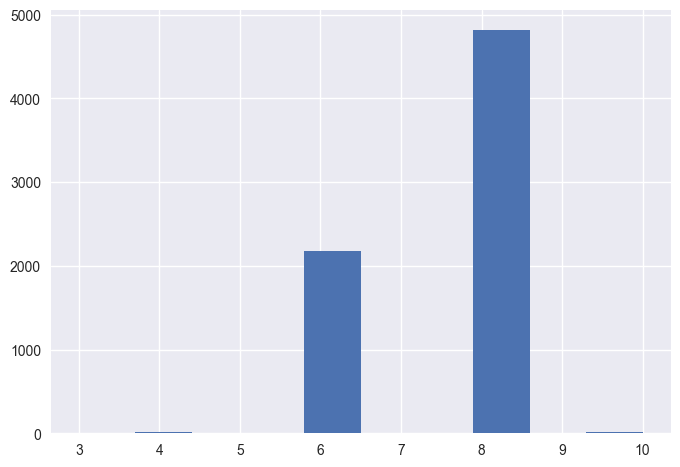

In [31]:
data['cylinders'].hist()